In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D, axes3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from matplotlib.artist import setp
from matplotlib.ticker import FormatStrFormatter
from IPython.display import set_matplotlib_formats
from matplotlib.collections import PolyCollection
sns.set()
sns.set_context("paper")
sns.set_color_codes("pastel")

sns.set_context({"figure.figsize": (16, 10)})
plt.style.use('seaborn-white')

In [2]:
def read_classification_file(path: str): 
    lookup = {}
    categories = {}
    with open(path) as f:
        for line in f:
            parts = line.split()
            id_parts = parts[0].split('-')
            if len(id_parts) == 4:
                _id = ''.join(id_parts[:3])+'-'+id_parts[3]
            else:
                _id = parts[0]
            if len(parts) != 2:
                print(line)
            else:    
                if parts[1] not in categories:
                    categories[parts[1]] = set()
                    
                categories[parts[1]].add(_id)
                lookup[_id] = parts[1]
                
    return lookup, categories

In [3]:
def read_features_file(path: str, classified):
    out = {}
    seen = {}
    with open(path) as f:
        for line in f:
            parts = line.split()
            features = []
            id_parts = parts[0].split('-')
            doc = ''
            if len(id_parts) == 4:
                doc = ''.join(id_parts[:3])
                _id = ''.join(id_parts[:3])+'-'+id_parts[3]
            else:
                _id = parts[0]
                
            features.append(int(id_parts[-1]))
                
            for p in parts[1:]:
                features.append(float(p))
                
            if doc in seen and _id in classified: 
                    features.append(seen[doc])
            else: 
                features.append(0)
                if doc not in seen or seen[doc] == 0: 
                    if _id in classified and classified[_id] == 'law':
                        seen[doc] = 1
                else:
                    seen[doc] = 0
                
            out[_id] = features
    return out 

In [7]:
classified_path = '/home/danlocke/go/src/github.com/dan-locke/phd-data/para-classification.txt'
features_path = '/home/danlocke/go/src/ner-train/out.txt'

classified_lookup, categories = read_classification_file(classified_path)

2018FCA0884-83 


In [8]:
features_lookup = read_features_file(features_path, classified_lookup)

In [9]:
def combine_lookup(features, classified): 
    prev_doc = '' 
    prev = ''
    out = {}
    for _id in features:
        doc = _id.split('-')[0]
        if doc == prev_doc: 
            if features[_id][2] == 1: 
                for i in range(1, len(features[prev])):
                    features[prev][i] += features[_id][i]
            else: 
                prev = _id 
                out[_id] = features[_id]
        
        prev_doc = doc             
        
    return out 

combined_lookup = combine_lookup(features_lookup, classified_lookup)

In [10]:
features = {x: features_lookup[x] + [classified_lookup[x]] for x in features_lookup if x in classified_lookup}

In [11]:
combined_features = {x: combined_lookup[x] + [classified_lookup[x]] for x in combined_lookup if x in classified_lookup}

In [16]:
features_df = pd.DataFrame.from_dict(features, orient='index', columns=['pos', 'para_num', 'quote', 'num_tokens', 'num_day', 'num_date', 'num_time', 'num_month', 'num_cit', 'num_case', 'num_cl', 'num_sec', 'num_leg', 'num_pin', 'num_ref', 'num_para', 'num_enum', 'num_judg', 'num_court', 'num_person', 'num_party', 'num_coy', 'num_acn', 'num_abn', 'num_ent', 'num_money', 'num_percent', 'num_ground', 'num_ex', 'num_pld', 'num_tscpt', 'num_ab', 'num_decno', 'num_fileno', 'num_report', 'num_order', 'num_secondary', 'seen_law', 'type'])
combined_features_df = pd.DataFrame.from_dict(combined_features, orient='index', columns=['pos', 'para_num', 'quote', 'num_tokens', 'num_day', 'num_date', 'num_time', 'num_month', 'num_cit', 'num_case', 'num_cl', 'num_sec', 'num_leg', 'num_pin', 'num_ref', 'num_para', 'num_enum', 'num_judg', 'num_court', 'num_person', 'num_party', 'num_coy', 'num_acn', 'num_abn', 'num_ent', 'num_money', 'num_percent', 'num_ground', 'num_ex', 'num_pld', 'num_tscpt', 'num_ab', 'num_decno', 'num_fileno', 'num_report', 'num_order', 'num_secondary', 'seen_law', 'type'])

# features_df = pd.DataFrame.from_dict(features, orient='index', columns=['pos', 'para_num', 'quote', 'num_tokens', 'num_person', 'num_entity', 'num_case', 'num_cit', 'num_sec', 'num_leg', 'num_ref', 'num_para', 'num_clause', 'num_money', 'num_pinpoint', 'num_judge', 'num_date', 'num_acn', 'num_abn', 'num_percent', 'num_time', 'num_order', 'seen_law', 'type'])
# combined_features_df = pd.DataFrame.from_dict(combined_features, orient='index', columns=['pos', 'para_num', 'quote', 'num_tokens', 'num_person', 'num_entity', 'num_case', 'num_cit', 'num_sec', 'num_leg', 'num_ref', 'num_para', 'num_clause', 'num_money', 'num_pinpoint', 'num_judge', 'num_date', 'num_acn', 'num_abn', 'num_percent', 'num_time', 'num_order', 'seen_law', 'type'])

In [18]:
features_df

,pos,para_num,quote,num_tokens,num_day,num_date,num_time,num_month,num_cit,num_case,...,num_pld,num_tscpt,num_ab,num_decno,num_fileno,num_report,num_order,num_secondary,seen_law,type
2018FCA0884-22,22,0.0,0.0,172.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,issues
2018FCA0884-23,23,1.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,fact
2018FCA0884-24,24,2.0,0.0,160.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,generic
2018FCA0884-26,26,624.0,31.0,1031.0,0.0,3.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,argument
2018FCA0884-27,27,5.0,1.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,argument
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018QSC027-128,128,127.0,1.0,31.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,fact
2018QSC027-129,129,128.0,1.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,fact
2018QSC027-130,130,129.0,1.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,fact
2018QSC027-131,131,130.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,fact


In [133]:
def num_para(df):
    out = {}
    for i in df.index:
        parts = i.split('-')
        if parts[0] not in out: 
            out[parts[0]] = int(parts[1])
        else:
            v = int(parts[1]) 
            if v > out[parts[0]]:
                out[parts[0]] = v
        
    return out 
doc_paras = num_para(features_df)
comb_doc_paras = num_para(combined_features_df)


def add_rel_pos(df, lookup):
    new = []
    for i in df.index: 
        parts = i.split('-')
        doc = lookup[parts[0]]
        new.append(float(parts[1])/float(doc))
    df['rel_pos'] = new
    
add_rel_pos(features_df, doc_paras)
add_rel_pos(combined_features_df, comb_doc_paras)

In [134]:
def calc(df):
    overall = df['type'].value_counts().to_dict()

    comp = {}
    for x in df.columns:
        if not (x == 'heading' or x == 'pos' or x == 'type' or x  == 'para_num' or x == 'num_tokens'):
            comp[x] = df[df[x] > 0]['type'].value_counts().to_dict()
    
    return comp, overall 

comp, overall = calc(features_df)
comp_comb, overall_comb = calc(combined_features_df)

In [135]:
(pd.DataFrame.from_dict(comp).T / pd.Series(overall)).T

,quote,num_person,num_entity,num_case,num_cit,num_sec,num_leg,num_ref,num_para,num_clause,...,num_pinpoint,num_judge,num_date,num_acn,num_abn,num_percent,num_time,num_order,seen_law,rel_pos
agreement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,0.090909,NaN,NaN,NaN,NaN,NaN,0.545455,1.0
annex,1.000000,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,...,NaN,0.111111,0.333333,0.111111,NaN,NaN,NaN,NaN,NaN,1.0
argument,0.525424,0.220339,0.627119,0.152542,0.135593,0.101695,0.101695,0.271186,0.135593,0.101695,...,0.169492,0.101695,0.237288,NaN,NaN,0.016949,NaN,NaN,0.322034,1.0
argument_fact,0.707547,0.245283,0.716981,0.018868,0.018868,0.009434,0.009434,0.283019,0.103774,0.075472,...,0.235849,0.056604,0.349057,NaN,NaN,0.028302,NaN,NaN,0.367925,1.0
argument_law,0.656250,0.234375,0.734375,0.203125,0.203125,0.312500,0.281250,0.312500,0.078125,0.031250,...,0.281250,0.093750,0.296875,NaN,NaN,NaN,NaN,NaN,0.312500,1.0
conclusion,0.325000,0.200000,0.408333,0.058333,0.041667,0.083333,0.075000,0.083333,0.058333,NaN,...,0.058333,0.125000,0.216667,0.016667,NaN,NaN,0.016667,NaN,0.491667,1.0
conclusion_fact,0.416667,0.166667,0.458333,0.083333,0.041667,NaN,NaN,0.041667,NaN,NaN,...,0.041667,NaN,0.291667,NaN,NaN,0.208333,NaN,NaN,NaN,1.0
fact,0.544715,0.260163,0.741870,0.022358,0.020325,0.026423,0.024390,0.264228,0.022358,0.060976,...,0.109756,0.050813,0.331301,0.004065,NaN,0.014228,0.004065,NaN,0.156504,1.0
generic,0.375000,0.250000,0.437500,0.046875,0.085938,0.164062,0.101562,0.242188,0.070312,NaN,...,0.062500,0.093750,0.234375,NaN,NaN,0.015625,NaN,NaN,0.343750,1.0
heading,0.692308,0.128205,0.256410,NaN,NaN,0.025641,0.051282,0.025641,NaN,NaN,...,NaN,NaN,0.128205,NaN,NaN,0.025641,NaN,NaN,0.256410,1.0


In [136]:
(pd.DataFrame.from_dict(comp_comb).T / pd.Series(overall_comb)).T

,quote,num_person,num_entity,num_case,num_cit,num_sec,num_leg,num_ref,num_para,num_clause,...,num_pinpoint,num_judge,num_date,num_acn,num_abn,num_percent,num_time,num_order,seen_law,rel_pos
agreement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,1.0
annex,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.0
argument,0.377778,0.288889,0.711111,0.200000,0.177778,0.111111,0.111111,0.355556,0.155556,0.111111,...,0.222222,0.133333,0.266667,NaN,NaN,0.022222,NaN,NaN,0.288889,1.0
argument_fact,0.326087,0.391304,0.739130,0.043478,0.043478,0.021739,0.021739,0.500000,0.108696,0.086957,...,0.347826,0.086957,0.478261,NaN,NaN,NaN,NaN,NaN,0.413043,1.0
argument_law,0.312500,0.343750,0.843750,0.250000,0.281250,0.437500,0.375000,0.468750,0.125000,0.062500,...,0.406250,0.156250,0.250000,NaN,NaN,NaN,NaN,NaN,0.218750,1.0
conclusion,0.109890,0.241758,0.450549,0.076923,0.054945,0.098901,0.098901,0.109890,0.076923,NaN,...,0.076923,0.131868,0.186813,0.010989,NaN,NaN,0.010989,NaN,0.373626,1.0
conclusion_fact,0.176471,0.235294,0.411765,0.058824,0.058824,NaN,NaN,0.058824,NaN,NaN,...,0.058824,NaN,0.352941,NaN,NaN,0.235294,NaN,NaN,NaN,1.0
fact,0.194139,0.355311,0.754579,0.025641,0.021978,0.032967,0.029304,0.326007,0.036630,0.069597,...,0.161172,0.080586,0.435897,0.003663,NaN,0.018315,0.003663,NaN,0.183150,1.0
generic,0.122222,0.344444,0.433333,0.044444,0.044444,0.211111,0.122222,0.177778,0.066667,NaN,...,0.044444,0.122222,0.233333,NaN,NaN,NaN,NaN,NaN,0.411111,1.0
heading,0.076923,0.307692,0.461538,NaN,NaN,0.076923,0.076923,0.076923,NaN,NaN,...,NaN,NaN,0.307692,NaN,NaN,NaN,NaN,NaN,0.153846,1.0


In [137]:
def calc_rule_var1(df, overall):
    return pd.Series(df[(df.num_case > 0) | (df.num_cit > 0) | (df.num_sec > 0) | (df.num_leg > 0)]['type'].value_counts().to_dict()) / pd.Series(overall)
    
def calc_rule_var2(df, overall):
    return pd.Series(df[(df.num_case > 0) | (df.num_cit > 0) | (df.num_sec > 0) | (df.num_leg > 0) | (df.num_judge > 0)]['type'].value_counts().to_dict()) / pd.Series(overall)

def calc_rule_var3(df, overall):
    return pd.Series(df[(df.num_case > 0) | (df.num_cit > 0) | (df.num_sec > 0) | (df.num_leg > 0) | (df.seen_law > 0)]['type'].value_counts().to_dict()) / pd.Series(overall)



print(calc_rule_var1(features_df, overall))
print('-'*30)
print(calc_rule_var1(combined_features_df, overall_comb))
print('-'*30)
print(calc_rule_var2(features_df, overall))
print('-'*30)
print(calc_rule_var2(combined_features_df, overall_comb))
print('-'*30)
print(calc_rule_var3(features_df, overall))
print('-'*30)
print(calc_rule_var3(combined_features_df, overall_comb))

agreement               NaN
annex                   NaN
argument           0.254237
argument_fact      0.028302
argument_law       0.500000
conclusion         0.133333
conclusion_fact    0.083333
fact               0.048780
generic            0.250000
heading            0.051282
issues             0.326087
law                0.560302
dtype: float64
------------------------------
agreement               NaN
annex                   NaN
argument           0.311111
argument_fact      0.065217
argument_law       0.625000
conclusion         0.164835
conclusion_fact    0.058824
fact               0.062271
generic            0.233333
heading            0.076923
issues             0.428571
law                0.805195
dtype: float64
------------------------------
agreement          1.000000
annex              0.111111
argument           0.271186
argument_fact      0.084906
argument_law       0.500000
conclusion         0.216667
conclusion_fact    0.083333
fact               0.089431
generic     

In [138]:
features_df['seen_law'].value_counts()

0     1118
1      388
2       13
3        9
4        8
6        4
5        3
10       2
8        2
23       1
16       1
13       1
7        1
Name: seen_law, dtype: int64

In [140]:
features_df.groupby('type').mean()

,pos,para_num,quote,num_tokens,num_person,num_entity,num_case,num_cit,num_sec,num_leg,...,num_pinpoint,num_judge,num_date,num_acn,num_abn,num_percent,num_time,num_order,seen_law,rel_pos
type,,,,,,,,,,,,,,,,,,,,,
agreement,56.090909,55.090909,0.000000,20.818182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.363636,0.090909,0.000000,0.0,0.000000,0.000000,0.0,0.545455,0.692813
annex,170.500000,330.055556,1.888889,18.388889,0.000000,0.888889,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.111111,0.555556,0.111111,0.0,0.000000,0.000000,0.0,0.000000,0.952514
argument,75.966102,126.000000,1.033898,103.186441,0.610169,2.491525,0.305085,0.322034,0.101695,0.135593,...,0.474576,0.152542,0.389831,0.000000,0.0,0.067797,0.000000,0.0,0.508475,0.499918
argument_fact,53.745283,83.584906,1.066038,78.424528,0.613208,2.632075,0.037736,0.037736,0.009434,0.018868,...,0.330189,0.084906,0.575472,0.000000,0.0,0.037736,0.000000,0.0,0.575472,0.314626
argument_law,89.468750,114.343750,0.734375,83.281250,0.531250,2.531250,0.531250,0.500000,0.703125,0.671875,...,0.546875,0.140625,0.343750,0.000000,0.0,0.000000,0.000000,0.0,0.343750,0.525927
conclusion,105.091667,133.016667,0.508333,72.683333,0.541667,1.608333,0.133333,0.125000,0.125000,0.125000,...,0.108333,0.233333,0.441667,0.016667,0.0,0.000000,0.016667,0.0,0.716667,0.810830
conclusion_fact,66.833333,89.208333,0.625000,102.583333,0.166667,1.000000,0.291667,0.208333,0.000000,0.000000,...,0.041667,0.000000,0.458333,0.000000,0.0,0.333333,0.000000,0.0,0.000000,0.696181
fact,80.398374,122.479675,0.888211,83.369919,0.676829,4.282520,0.032520,0.030488,0.044715,0.038618,...,0.193089,0.071138,0.727642,0.004065,0.0,0.016260,0.004065,0.0,0.215447,0.414000
generic,85.320312,96.539062,0.445312,87.750000,0.632812,5.039062,0.078125,0.093750,0.289062,0.171875,...,0.085938,0.117188,0.375000,0.000000,0.0,0.015625,0.000000,0.0,0.398438,0.578374


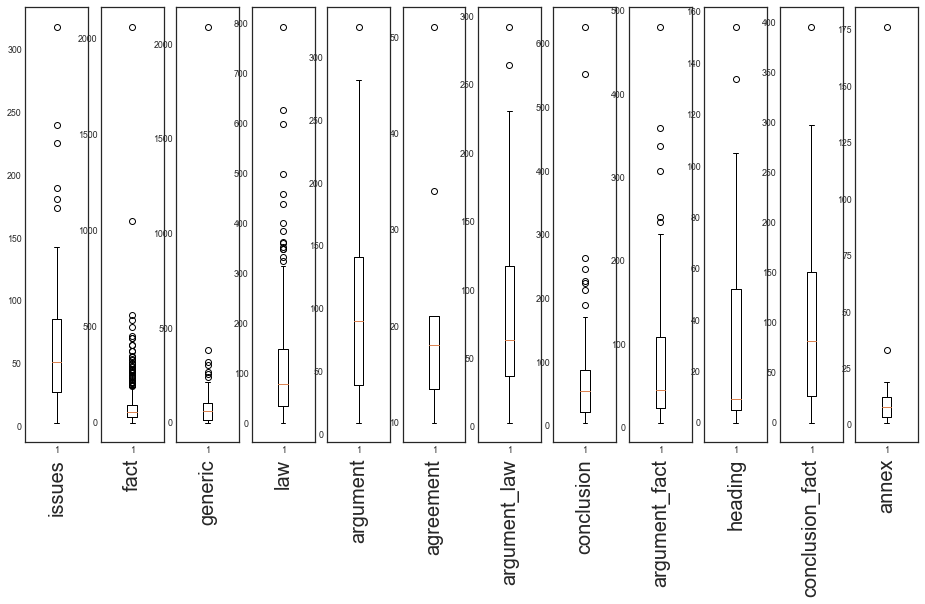

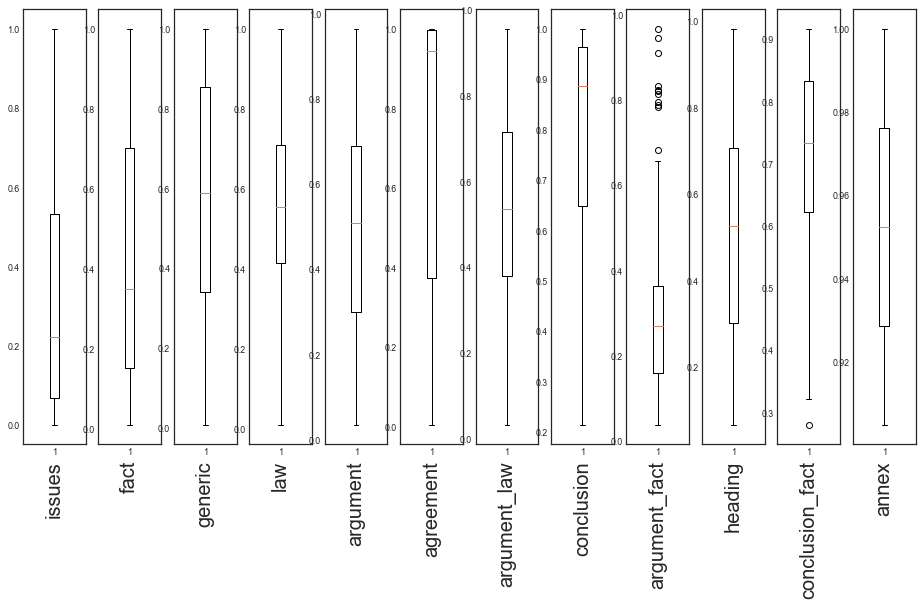

In [141]:
def plot_cat_box(df, feature: str):
    groups = df.groupby('type')
    types = df['type'].unique()
    fig, axs = plt.subplots(1, len(types))
    fig.set_size_inches(16, 8)
    for i in range(len(types)):
        axs[i].boxplot(df.loc[groups.groups[types[i]]][feature])
        axs[i].set_xlabel(types[i], fontsize='20', rotation=90)

plot_cat_box(features_df, 'num_tokens')
plot_cat_box(features_df, 'rel_pos')

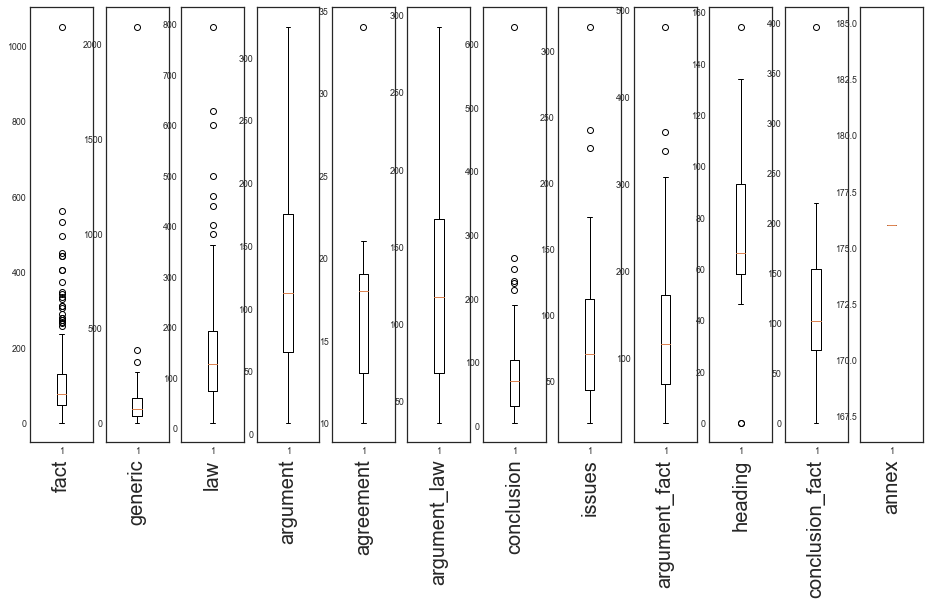

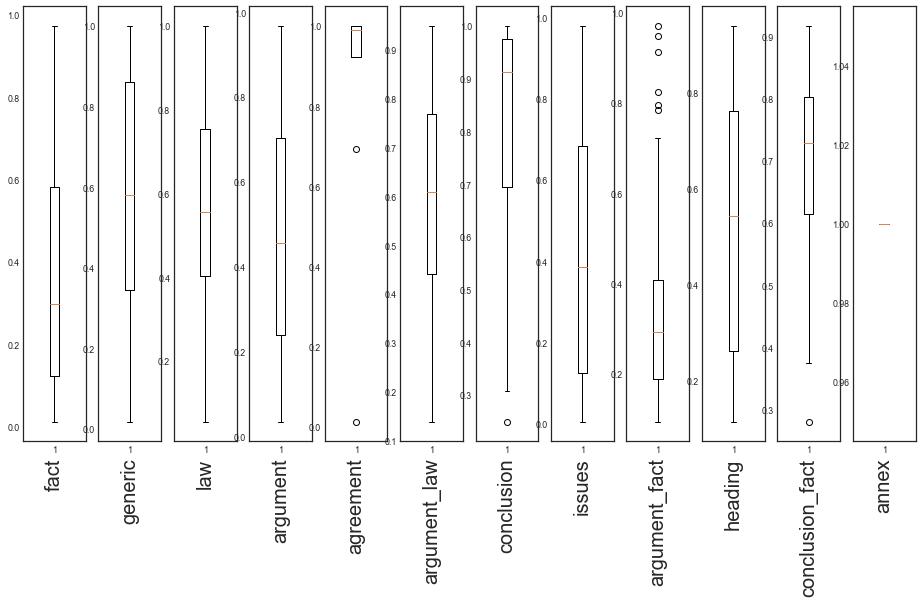

In [142]:
plot_cat_box(combined_features_df, 'num_tokens')
plot_cat_box(combined_features_df, 'rel_pos')

In [143]:
features_df['quote'].value_counts()

0.0     732
1.0     716
2.0      28
3.0      20
4.0      15
5.0      11
7.0       6
9.0       5
12.0      3
10.0      3
6.0       3
15.0      2
23.0      2
11.0      2
22.0      1
8.0       1
17.0      1
Name: quote, dtype: int64

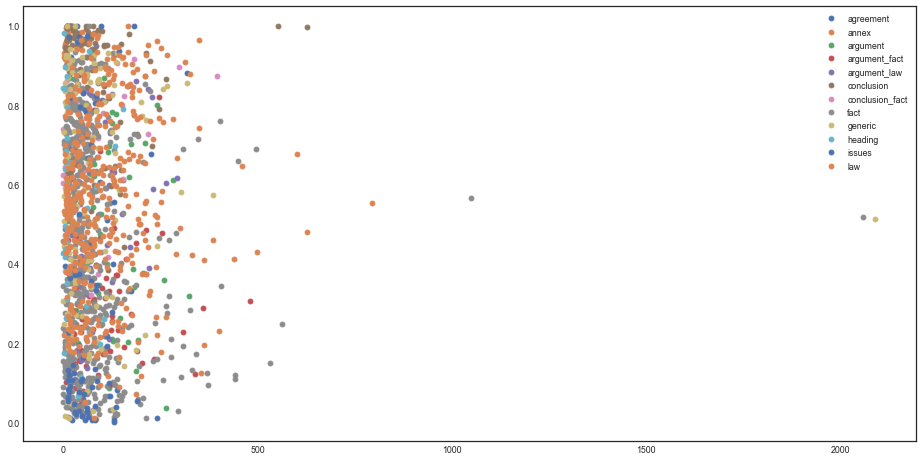

In [145]:
# fig = plt.subplot()
# fig.set_size_inches(16, 8)
# fig.scatter(features_df['num_tokens'], features_df['rel_pos'])
groups = features_df.groupby('type')

fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.num_tokens, group.rel_pos, marker='o', linestyle='', label=name)
ax.legend()

plt.show()

In [146]:
features_df[(features_df.index.str.contains('2000QCA011')) & ((features_df.num_case > 0) | (features_df.num_cit > 0) | (features_df.num_sec > 0) | (features_df.num_leg > 0))]
# features_df[]

,pos,para_num,quote,num_tokens,num_person,num_entity,num_case,num_cit,num_sec,num_leg,...,num_judge,num_date,num_acn,num_abn,num_percent,num_time,num_order,seen_law,type,rel_pos
2000QCA011-6,6,5.0,0.0,224.0,0.0,1.0,1.0,2.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,law,0.333333
2000QCA011-10,10,9.0,0.0,252.0,0.0,0.0,4.0,4.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1,law,0.555556
2000QCA011-11,11,10.0,0.0,146.0,0.0,4.0,7.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,law,0.611111
2000QCA011-12,12,11.0,0.0,146.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1,law,0.666667
2000QCA011-14,14,13.0,0.0,109.0,3.0,5.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,law,0.777778
2000QCA011-16,16,15.0,0.0,122.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,law,0.888889


In [147]:
features_df[features_df.index.str.contains('2000QCA011')]

,pos,para_num,quote,num_tokens,num_person,num_entity,num_case,num_cit,num_sec,num_leg,...,num_judge,num_date,num_acn,num_abn,num_percent,num_time,num_order,seen_law,type,rel_pos
2000QCA011-1,1,0.0,0.0,190.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0,issues,0.055556
2000QCA011-2,2,1.0,0.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0,fact,0.111111
2000QCA011-3,3,2.0,0.0,278.0,0.0,3.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0,fact,0.166667
2000QCA011-4,4,3.0,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0,generic,0.222222
2000QCA011-5,5,4.0,0.0,267.0,0.0,5.0,0.0,0.0,0.0,0.0,...,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0,fact,0.277778
2000QCA011-6,6,5.0,0.0,224.0,0.0,1.0,1.0,2.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,law,0.333333
2000QCA011-7,7,6.0,0.0,178.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,argument,0.388889
2000QCA011-8,8,7.0,0.0,242.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1,generic,0.444444
2000QCA011-9,9,8.0,0.0,197.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,generic,0.500000
2000QCA011-10,10,9.0,0.0,252.0,0.0,0.0,4.0,4.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1,law,0.555556
